In [1]:
# if local use new_torch_env

import os

import numpy as np
from scipy import stats
import pandas as pd
# import seaborn as sns

from collections import Counter

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from xml.etree import ElementTree, ElementInclude

import pickle
from functools import reduce

import iptcinfo3
from iptcinfo3 import IPTCInfo

import detectron2

from utills_output import *

# TODO

- [ ] **gen annotated dfs for all thresholds range(0.1, 0.76, 0.01)**
- [ ] make work for full

In [2]:
def feature_dist_plots(df, result = 'mean', feature_version = 'mean'): # feature should be all and go inside.. but then you need mean first or it gets messig...

    """Df can be one df with a given threshold. Result can be 'mean' or 'dummy'.
    Feature version can be a model short, eg. 'fasterX101' or retinaR50. 
    It can also be a ensamble indication e.g. mean or median."""
    max_result = 0 # for plotting xticks..
    pub_status = df['custom2'].unique()

    # raw = df[df['custom2'] == 'Raw'][feature]
    # Published

    plt.figure(figsize= [15,15])
    fig_name = f'feature_dist_plots_{result}'

    for i, j in enumerate(pub_status):

        # ratio_list = []
        result_list = []
        feature_list = []

        for f in df.columns[df.columns.str.endswith(feature_version)]:
            
            N = df[df['custom2'] == j][f].shape[0]

            if result == 'mean':
                mean_result = df[df['custom2'] == j][f].mean()
                result_list.append(mean_result)
                plt.xlabel('Mean count of objects cross subsets of images (Raw, Submitted, Published)', fontsize = 14)

                max_result = max(mean_result, max_result)# for plotting xticks..
                ticks_w = 0.2
    

            elif result == 'dummy':
                dummy_result = (df[df['custom2'] == j][f] > 0).mean()
                result_list.append(dummy_result)
                plt.xlabel('non-zero count of objects cross subsets of images (Raw, Submitted, Published)', fontsize = 14)

                max_result = max(dummy_result, max_result)# for plotting xticks..
                ticks_w = 0.05

            feature_list.append(f)
            
                
        plt.title(f'Ensample resutls')

        plt.barh(np.arange(0+(i/4), len(result_list)+(i/4), 1), result_list, height= 0.25, alpha = 0.5, label = f'{j} (N = {N})')
        
    plt.yticks(np.arange(0+(1/4), len(result_list)+(1/4), 1), feature_list, fontsize = 16, label = f'{j} (N = {N})')
    plt.xticks(np.arange(0, max_result + ticks_w, ticks_w))

    plt.legend(fontsize = 14, loc = 'upper right')

    #plt.savefig(f'{fig_name}.pdf', bbox_inches="tight")   

    plt.show()

In [3]:
def feature_corr_plot(new_df):

    list_of_features_mean = [feature for feature in new_df.columns if 'mean' in feature]

    list_of_corr = []
    list_of_features = []

    for i, feature_mean in enumerate(list_of_features_mean):

        feature = feature_mean.split("_")[0]
        list_of_features.append(feature)
        feature_annotated = f'{feature}_annotated'

        corr_score = new_df[[feature_mean,feature_annotated]].corr(method='pearson').values[0,1]
        list_of_corr.append(corr_score)

    dict_of_corr = {'features': list_of_features, 'corr' : list_of_corr}

    df_corr = pd.DataFrame(dict_of_corr)
    df_corr.sort_values('corr', ascending= False, inplace = True)
    df_corr.reset_index(drop= True, inplace= True)


    plt.figure(figsize= [15,15])
    plt.barh(df_corr.index, df_corr['corr']**2)
    plt.yticks(df_corr.index, df_corr['features'], fontsize = 16)
    plt.xticks(fontsize = 16)
    plt.xlabel("$R^2$ between the number of classified objects and the annotated objects", fontsize = 16)

    plt.vlines(0.1, -1, df_corr.index.max()+1, colors= 'red', linestyles='dashed')

    plt.savefig(f'annotated_correlation.pdf', bbox_inches="tight") 
    plt.show()
        

In [4]:
def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions. 
    From https://medium.com/@sourcedexter/how-to-find-the-similarity-between-two-probability-distributions-using-python-a7546e90a08d
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (stats.entropy(p, m) + stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

In [5]:
def open_df(full = False, threshold = 0.3):
    
    path = '/home/simon/Documents/Bodies/data/OD_dataframes'

    if full == True:
        df_name = f'OD_DF_FULL_t{int(threshold*100)}.pkl'

    elif full == False:
        df_name = f'OD_DF_annotated_t{int(threshold*100)}.pkl'

    print(f'loading: {df_name}')

    df_path = os.path.join(path, df_name)

    with open(df_path, 'rb') as file:
        df = pickle.load(file)

    return(df)

In [6]:
def get_df_dict(full = False):

    df_dict = {}
#-------------------------------
    path = '/home/simon/Documents/Bodies/data/OD_dataframes'

    for root, dirs, files in os.walk(path):

        if full == False:
            ts_list = [file for file in files if file.split('_')[2] == 'annotated']

        elif full == True:
            ts_list = [file for file in files if file.split('_')[2] == 'FULL']
        
        t_range = [float(file.split('_')[-1].split('.')[0].split('t')[1])/100 for file in ts_list]
        t_range = sorted(np.array(t_range))
# ---------------------------------

    for t in t_range:
        df_name = f'df_t{int(t*100)}'
        df_dict[df_name] = open_df(full, t)
        print(f'Done w/ {df_name}', end='\r')

    return(df_dict)

In [7]:
def get_JSD(feature):
    
    best_corr = 0 # just initial value to beat
    best_JSD = np.inf # just initial value to beat
    best_dict = {'feature':feature}
    for k in df_dict.keys():
        feature_mean = f'{feature}_mean'
        feature_annotated = f'{feature}_annotated'
        if feature_mean in np.array(df_dict[k].columns):
            #print(k, end = ': ')
            pk = df_dict[k][feature_mean] # is there strickly any reason you are not using a sample from the full set?
            qk = df_dict[k][feature_annotated]
            JSD = jensen_shannon_distance(pk, qk)
            corr = np.corrcoef(pk, qk)[0,1]            
            #KLD  = stats.entropy(pk, qk)
            #print(f'{JSD:.3f}')
            if JSD < best_JSD:
                best_JSD = JSD
                best_dict['JSD'] = best_JSD
                best_dict['df_JSD'] = f'{k.split("_")[1]}'

            if np.abs(corr) > best_corr:
                best_corr = corr
                best_dict['corr'] = best_corr
                best_dict['df_corr'] = f'{k.split("_")[1]}'            

            # Then really you want to save the best df.

        else:
            pass

    return(best_dict)


In [8]:
def find_best_ts(df_dict):

    best_ts = []

    for f in df_dict['df_t10'].columns[df_dict['df_t10'].columns.str.endswith('annotated')]:
        feature = f.split('_')[0]
        #print(feature)
        best_dict = get_JSD(feature)
        best_ts.append(best_dict)
        #print('\n')

    return(best_ts)

In [9]:
# make a df out of the best mean feautres. 
def get_new_df(df_dict, best_ts):

    # perhaps you should only here keep stuff with corr > 0.1

    new_df_dict = {}

    for feature in best_ts: # since you always use the annotated best_ts, you can do this for FULL as well

        if feature['corr'] >= 0.1: #only keep correlated stuff

            df_name = f'df_{feature["df_JSD"]}'
            feature_name = f'{feature["feature"]}_mean'
            new_df_dict[feature_name] = df_dict[df_name][feature_name]

    new_df = pd.DataFrame(new_df_dict)
    new_df['img_id'] = df_dict['df_t10']['img_id'] # could just merge on index

    # relevant features. does not matter which df they come from
#    new_df['custom2'] = df_dict['df_t10']['custom2']

    feature_list = ['person_annotated', 'child_annotated', 'male_annotated', 'adult_annotated',
                    'youth_annotated', 'falgIRQ_annotated', 'female_annotated', 'religiousGarmentFemale_annotated',
                    'uniformed_annotated', 'firearm_annotated', 'flagUS_annotated', 'infant_annotated',
                    'bloodedArea_annotated', 'militaryVehicle_annotated', 'prayerInformal_annotated',
                    'hostage_annotated', 'casualty_annotated', 'elderly_annotated', 'prayerSalah_annotated', 
                    'custom2' ,'date created', 'time created', 'img_id']

    new_large_df = new_df.merge(df_dict['df_t10'][feature_list], on='img_id', how='inner')

    return(new_large_df)

# Note:
The annotated df are automatically generated via the script "range_of_annotated_df.py". Could also be generated one at a time via "output_to_df.py"

In [10]:
df_dict = get_df_dict(False)
best_ts = find_best_ts(df_dict)
new_df = get_new_df(df_dict, best_ts)

loading: OD_DF_annotated_t10.pkl
loading: OD_DF_annotated_t11.pkl
loading: OD_DF_annotated_t12.pkl
loading: OD_DF_annotated_t13.pkl
loading: OD_DF_annotated_t14.pkl
loading: OD_DF_annotated_t15.pkl
loading: OD_DF_annotated_t16.pkl
loading: OD_DF_annotated_t17.pkl
loading: OD_DF_annotated_t18.pkl
loading: OD_DF_annotated_t19.pkl
loading: OD_DF_annotated_t20.pkl
loading: OD_DF_annotated_t21.pkl
loading: OD_DF_annotated_t22.pkl
loading: OD_DF_annotated_t23.pkl
loading: OD_DF_annotated_t24.pkl
loading: OD_DF_annotated_t25.pkl
loading: OD_DF_annotated_t26.pkl
loading: OD_DF_annotated_t27.pkl
loading: OD_DF_annotated_t28.pkl
loading: OD_DF_annotated_t30.pkl
loading: OD_DF_annotated_t31.pkl
loading: OD_DF_annotated_t32.pkl
loading: OD_DF_annotated_t33.pkl
loading: OD_DF_annotated_t34.pkl
loading: OD_DF_annotated_t35.pkl
loading: OD_DF_annotated_t36.pkl
loading: OD_DF_annotated_t37.pkl
loading: OD_DF_annotated_t38.pkl
loading: OD_DF_annotated_t39.pkl
loading: OD_DF_annotated_t40.pkl
loading: O

/home/simon/anaconda3/envs/new_torch_env/lib/python3.8/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/simon/anaconda3/envs/new_torch_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/simon/anaconda3/envs/new_torch_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [11]:
best_ts

[{'feature': 'person',
  'JSD': 0.12632683452271762,
  'df_JSD': 't30',
  'corr': 0.8850739598778067,
  'df_corr': 't28'},
 {'feature': 'child',
  'JSD': 0.6550527304875435,
  'df_JSD': 't23',
  'corr': 0.339117446784712,
  'df_corr': 't16'},
 {'feature': 'male',
  'JSD': 0.2173006550591599,
  'df_JSD': 't22',
  'corr': 0.831222271815378,
  'df_corr': 't21'},
 {'feature': 'adult',
  'JSD': 0.24618800650833264,
  'df_JSD': 't17',
  'corr': 0.736869045583153,
  'df_corr': 't19'},
 {'feature': 'youth',
  'JSD': 0.6697253475376406,
  'df_JSD': 't24',
  'corr': 0.43818919078351914,
  'df_corr': 't14'},
 {'feature': 'falgIRQ',
  'JSD': 0.3343868393725932,
  'df_JSD': 't46',
  'corr': 0.8814875057290394,
  'df_corr': 't37'},
 {'feature': 'female',
  'JSD': 0.5878006056984579,
  'df_JSD': 't24',
  'corr': 0.3783266391041778,
  'df_corr': 't18'},
 {'feature': 'religiousGarmentFemale',
  'JSD': 0.6464699829188505,
  'df_JSD': 't26',
  'corr': 0.3678341250138183,
  'df_corr': 't18'},
 {'feature':

In [12]:
new_df

,person_mean,child_mean,male_mean,adult_mean,youth_mean,falgIRQ_mean,female_mean,religiousGarmentFemale_mean,uniformed_mean,firearm_mean,...,bloodedArea_annotated,militaryVehicle_annotated,prayerInformal_annotated,hostage_annotated,casualty_annotated,elderly_annotated,prayerSalah_annotated,custom2,date created,time created
0,6.0,0.5,5.0,4.0,0.0,0.0,0.5,0.0,0.4,1.0,...,0,0,0,0,0,1,0,Raw,20040114,020325
1,4.2,0.0,3.4,3.6,0.0,0.0,0.0,0.0,0.4,0.0,...,0,0,0,0,0,0,0,Raw,20031224,004743
2,1.0,0.0,0.8,0.8,0.5,0.4,0.0,0.0,0.6,0.0,...,0,0,0,0,0,0,0,Raw,20050810,163053
3,5.4,0.5,5.0,3.4,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,Raw,20050428,050609+0300
4,2.4,0.0,1.2,1.8,0.0,0.0,0.0,0.0,1.4,0.8,...,0,0,0,0,0,0,0,Raw,20051110,090330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,2.0,0.0,0.8,1.2,0.0,0.0,0.0,0.0,1.6,0.0,...,0,0,0,0,0,0,0,Raw,20051108,111930
1003,5.0,0.5,4.8,3.4,0.0,0.0,0.5,0.0,0.2,0.0,...,0,0,0,0,0,0,0,Raw,20050430,094011
1004,1.2,0.5,1.0,0.6,0.0,0.0,1.0,0.5,0.0,0.0,...,0,0,0,0,0,0,0,Raw,20030504,091335
1005,2.6,0.0,2.2,2.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,Raw,20050331,151258


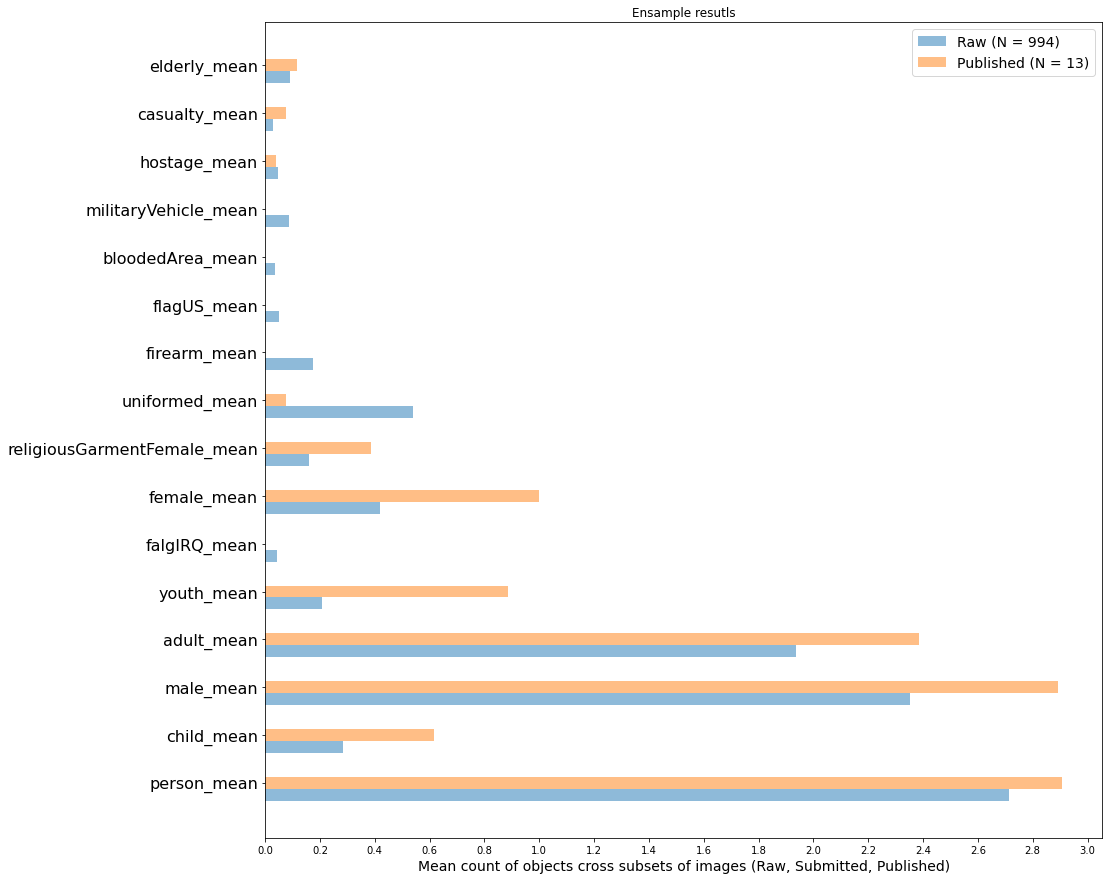

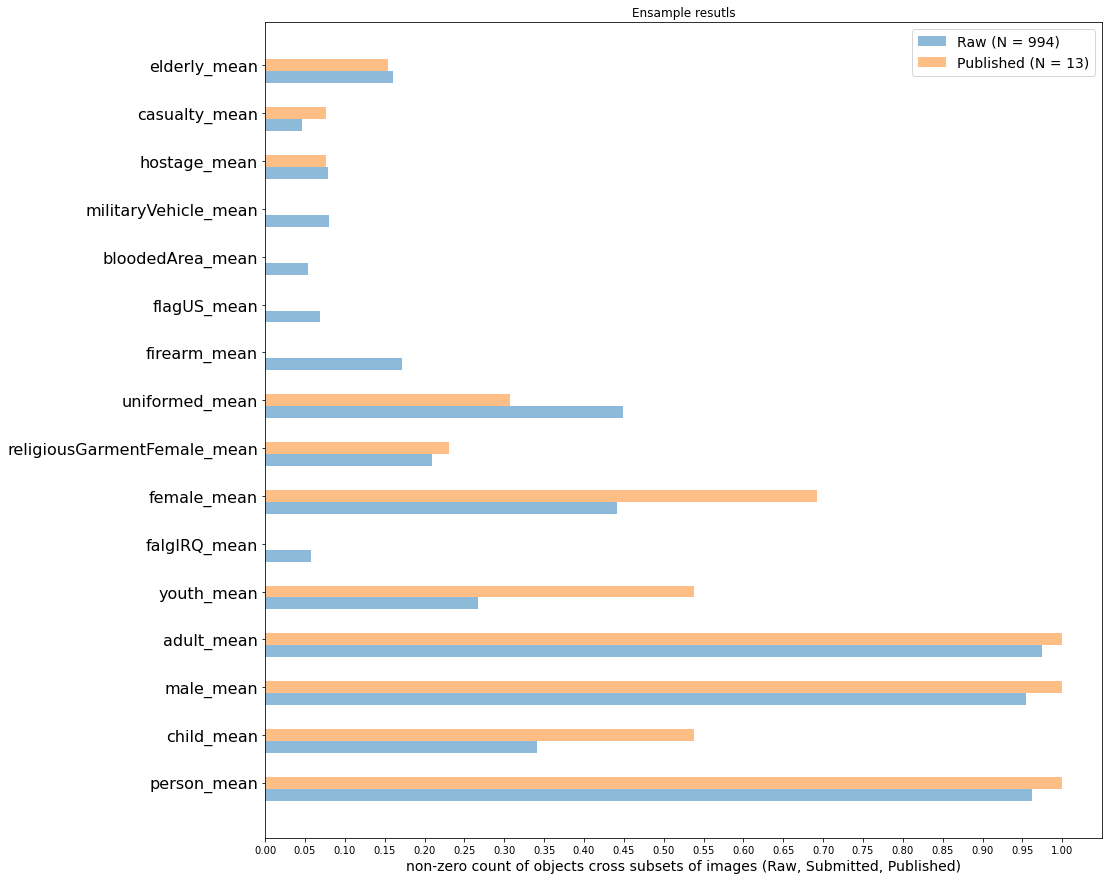

In [13]:
feature_dist_plots(new_df, 'mean')
feature_dist_plots(new_df, 'dummy')

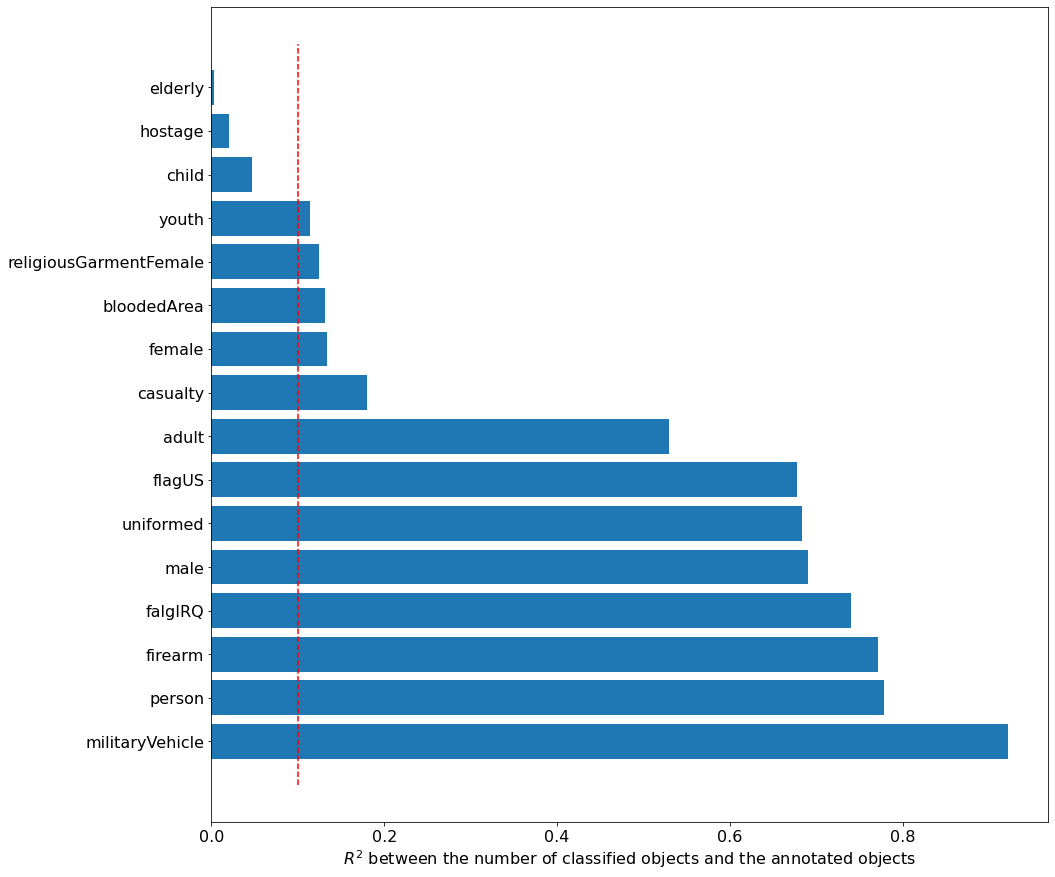

In [14]:
feature_corr_plot(new_df)